# Generative Adversarial networks (GAN)

GANs are a type of neural network used for **unsupervised machine learning**. They are comprised of two adversarial modules: generator and cost (discriminator) networks. These modules compete with each other such that the cost network tries to filter fake examples while the generator tries to trick this filter by creating realistic examples. Through this competition, the model learns a generator that creates realistic data. They can be used in tasks such as future predictions or for generating images after being trained on a particular dataset.

![Alt text](gan.png)

At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, we would do a two-sample test. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way.

The discriminator is a binary classifier to distinguish if the input is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction for its input $x$, such as using a fully connected layer with hidden size 1 ($y = f(x|\theta_D) \in R$), and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-y})$. Assuming $y = 1$ for true data and $y=0$ for fake data, we train the discriminator to minimize the cross-entropy loss:

\begin{align}
min_{\theta_D} \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \}
\end{align}


For the generator, we assume the existence of a latent variable $z \in R^d$ (e.g. $z \sim N(0, I_d)$). The output of the generator is then $\tilde{x} = G(z|\theta_G)$. We want to train $G$ to generate values of $\tilde{x}$ that can fool the discriminator i.e. for a given discirminator $D$, we update the parameters of G to maximize 
\begin{align}
\max_{\theta_G} \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \}
\end{align}

All in all, the problem we want to solve is:

\begin{align}
max_{\theta_G} min_{\theta_D} -[E_{x \sim P_X} log(D(x)) + E_{z \sim noise} log(1 - D(G(z)))]
\end{align}

## Exemple: Generating points from a given distribution

In [48]:
import torch
from torch import nn
from tqdm import tqdm

In [138]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

In [137]:
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


In [128]:
net_G = nn.Sequential(nn.Linear(2, 2))
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
    )

In [129]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,))
    zeros = torch.zeros((batch_size,))
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = 0.5*(loss(real_Y, ones.reshape(real_Y.shape)) + loss(fake_Y, zeros.reshape(fake_Y.shape)))
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,))
    trainer_G.zero_grad()
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape)) # loss(real_Y, zeros.reshape(fake_Y.shape)) = 0
    loss_G.backward()
    trainer_G.step()
    return loss_G

def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    list_loss_D = []
    list_loss_G = []
    list_fake_X = []
    for _ in tqdm(range(num_epochs)):
        for X in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric = [update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size]
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        list_loss_D.append(float(loss_D.detach()))
        list_loss_G.append(float(loss_G.detach()))
        list_fake_X.append(fake_X)
    return list_loss_D, list_loss_G, list_fake_X

In [97]:
lr_D, lr_G, latent_dim, num_epochs, batch_size = 0.05, 0.005, 2, 50, 8
data_iter = torch.utils.data.DataLoader(data.reshape(-1, 1, 2), batch_size, shuffle=True)
list_loss_D, list_loss_G, list_fake_X = train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,latent_dim, data[:100].detach().numpy())

100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


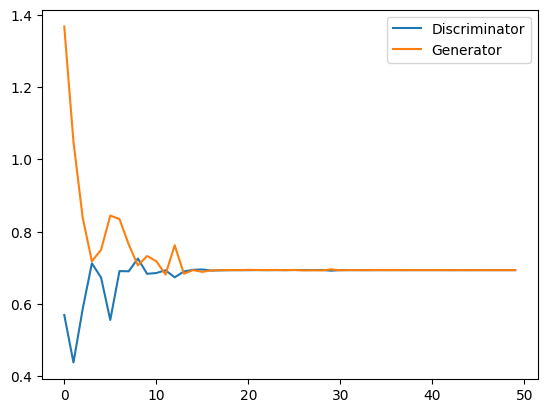

In [103]:
import matplotlib.pyplot as plt
x = [k for k in range(0, num_epochs)]
plt.plot(x, list_loss_D, label='Discriminator')
plt.plot(x, list_loss_G, label='Generator')
plt.legend()

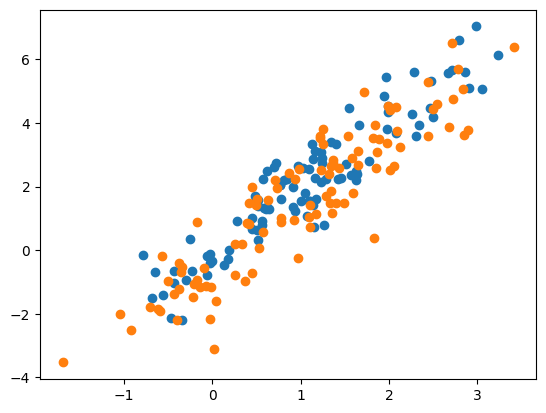

In [139]:
plt.scatter(x = data[:100, 0], y = data[:100, 1], label='real')
fake = list_fake_X[-1]
plt.scatter(x = fake[:, 0], y = fake[:, 1], label='real')

In [121]:
import statsmodels.api as sm
fake_x = fake[:, 0]
fake_y = fake[:, 1]
true_x = data[:100, 0]
true_y = data[:100, 1]

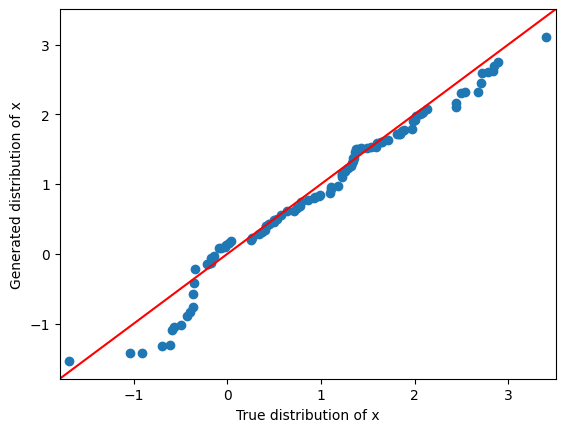

In [123]:
sm.qqplot_2samples(fake_x, true_x, line='45', xlabel = "True distribution of x", ylabel="Generated distribution of x")
plt.show()

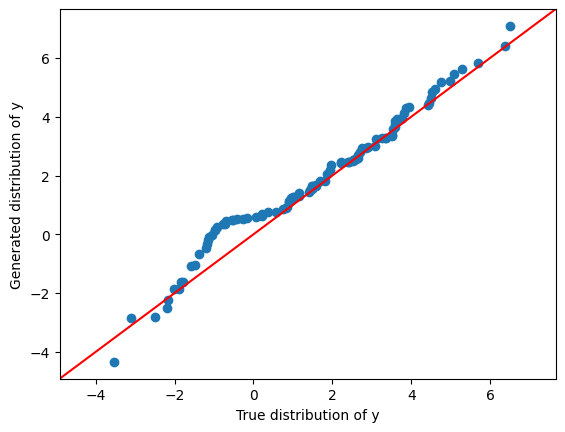

In [125]:
sm.qqplot_2samples(fake_y, true_y, line='45', xlabel = "True distribution of y", ylabel="Generated distribution of y")
plt.show()

## Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the sample as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss.
* The discriminator tries to distinguish the generated samples from the true samples, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.